In [1]:
!pip install -q openai

In [2]:
!pip install -q openai --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.8/787.8 kB 11.3 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI

client = OpenAI(api_key="add_your_api_key_here")

Saving complex_facade.svg to complex_facade.svg
Uploaded file: complex_facade.svg


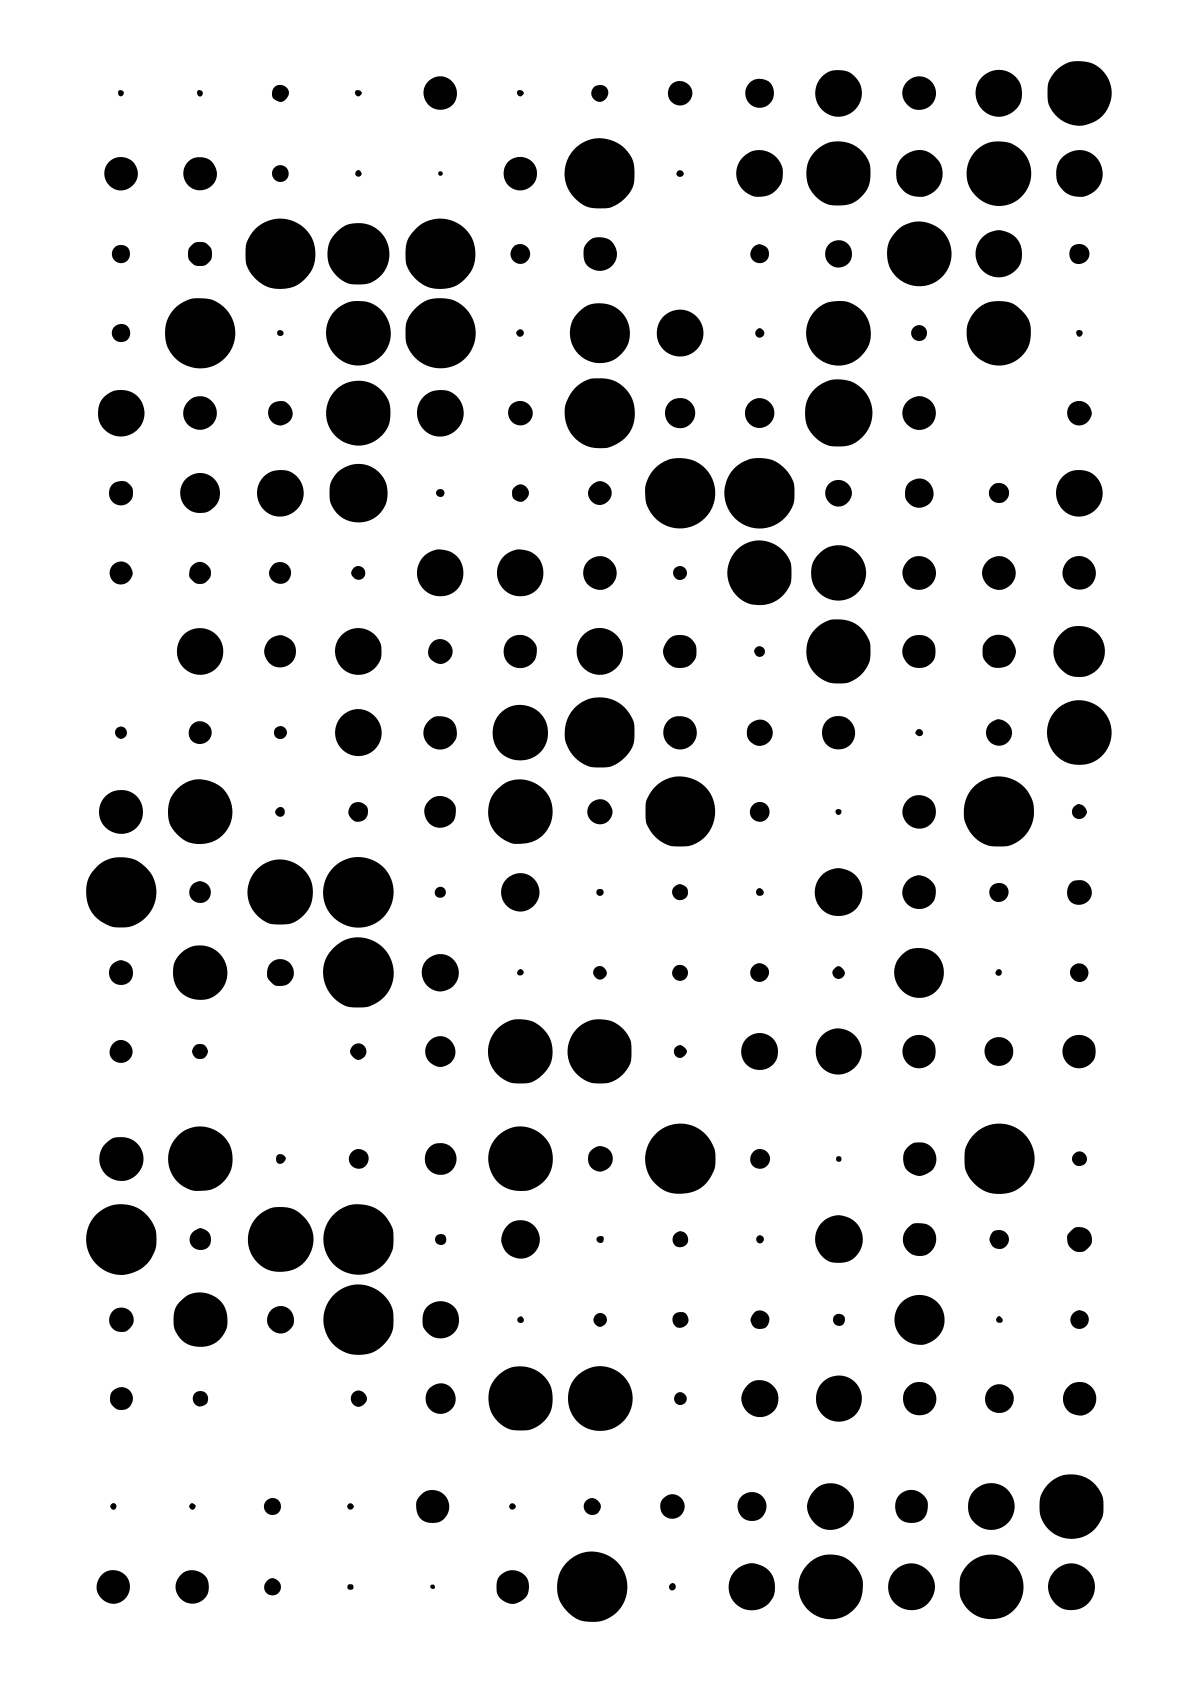

In [4]:
from google.colab import files
from IPython.display import SVG, display

# Upload the file (a dialog will appear)
uploaded = files.upload()

svg_content = next(iter(uploaded))
print("Uploaded file:", svg_content)
display(SVG(svg_content))

In [5]:
# # Load SVG
# with open("mask_output.svg", "r") as f:
#     svg_content = f.read()

# Prompt
prompt = (
    "Here is an SVG file. Make red windows the same height, make green windows the same height as red ones."
    "The are several floors, all windows need to be one line with a corresponding floor"
    "Only return valid SVG code. Do not add ```xml or any markdown formatting.\n\n"
    + svg_content
)

# Call GPT-4
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0.2
)

modified_svg = response.choices[0].message.content

# Save result
with open("adjusted_result.svg", "w") as f:
    f.write(modified_svg)

print("✅ SVG updated and saved.")

KeyboardInterrupt: 

In [ ]:
from openai import OpenAI
import os

input_svg_path = "adjusted_result.svg"
with open(input_svg_path, "r", encoding="utf-8") as f:
    svg_content = f.read()

# Prompt
instruction = (
    "Here is an SVG file. Make the green windows twice higher to the upper level. "
    "Only return valid SVG code. Do not add ```xml or any markdown formatting.\n\n"
    + svg_content
)

# LLM model
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": instruction}
    ],
    temperature=0.2
)

raw_response = response.choices[0].message.content.strip()

# Remove markdown formatting if GPT didn't follow instructions
if raw_response.startswith("```xml") or raw_response.startswith("```"):
    raw_response = raw_response.strip("` \n")
    lines = raw_response.splitlines()
    # Remove first line if it's a markdown header
    if lines[0].lower().startswith("xml") or lines[0].startswith("<svg") is False:
        raw_response = "\n".join(lines[1:])

# Save cleaned output
output_svg_path = "modified_windows.svg"
with open(output_svg_path, "w", encoding="utf-8") as f:
    f.write(raw_response)

print(f"✅ SVG saved to: {output_svg_path}")


#Black and white PNG image

In [ ]:
# !pip install cairosvg

In [ ]:
# import cv2
# import numpy as np
# import cairosvg
# from matplotlib import pyplot as plt

# # --- 1. Convert SVG to PNG ---
# cairosvg.svg2png(url="modified_windows.svg", write_to="temp_rendered.png", output_width=1024, output_height=1024)

# # --- 2. Load the rendered PNG ---
# image = cv2.imread("temp_rendered.png")

# # --- 3. Convert to grayscale ---
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # --- 4. Threshold to get binary mask (white boxes, black background) ---
# _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# # --- 5. Display the result ---
# plt.imshow(mask, cmap='gray')
# plt.axis('off')
# plt.title("Black and White Mask from SVG")
# plt.show()

# # --- 6. Save if needed ---
# cv2.imwrite("black_white_mask_from_svg.png", mask)


# Coverting SVG to JSON (if needed)

Converting to JSON using LLM

It takes some time, not fast

The window coordinates after LLM are not correct. They need to be corrected using Step 2.

STEP 1

In [ ]:
import os
import json
import re
from openai import OpenAI


# 1. Load SVG content
# ================================
svg_path = "/content/complex_facade.svg"
with open(svg_path, "r") as f:
    svg_content = f.read()

# ================================
# 2. Enhanced Shape Classification Prompt
# ================================
instruction = f"""
You are given an SVG file containing window elements. Analyze each element and classify its shape.
Parse it into JSON with this EXACT structure:

{{
  "canvas": {{ "width": int, "height": int }},
  "grid": {{ "floors": int, "bays": int, "spacing_x": int, "spacing_y": int, "offset_x": int, "offset_y": int }},
  "window": {{ "width": int, "height": int, "inset": int }},
  "components": [
    {{
      "x": int,         // left position in canvas, between 0 and canvas width
      "y": int,         // top position in canvas, between 0 and canvas height
      "w": int,         // width
      "h": int,         // height
      "shape": "rect|arch|round|oval|triangle|hexagon",  // MUST be one of these
      "col": int,       // grid column
      "row": int,       // grid row
    }}
  ],
  "use_grid": true|false
}}

SHAPE CLASSIFICATION RULES:
1. "rect": Straight sides, 90° corners, quadrilateral
2. "arch": Rectangular with arched/semi-circular top
3. "round": Perfect circle or nearly circular
4. "oval": Elliptical shape, longer than wide
5. "triangle": Three-sided shape
6. "hexagon": Six-sided shape

PATH PROCESSING:
1. Calculate bounding box for each path to determine position and size
2. Analyze path geometry to determine shape classification
3. For ambiguous cases, choose the closest matching shape

OUTPUT REQUIREMENTS:
- ONLY valid JSON output
- NO explanations
- NO markdown formatting
- NO additional text

SVG FILE CONTENT:
{svg_content}
"""

resp = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": instruction}],
    temperature=0.0
)

raw_json = resp.choices[0].message.content.strip()

# ================================
# 3. Clean and Validate Output
# ================================
if raw_json.startswith("```"):
    raw_json = re.sub(r"^```[a-zA-Z]*\n?", "", raw_json)
    raw_json = raw_json.rstrip("`").strip()

# Validate shape types
valid_shapes = {"rect", "arch", "round", "oval", "triangle", "hexagon"}

try:
    data = json.loads(raw_json)
    for comp in data.get("components", []):
        if comp["shape"] not in valid_shapes:
            raise ValueError(f"Invalid shape '{comp['shape']}'. Must be one of: {valid_shapes}")
except (json.JSONDecodeError, ValueError) as e:
    print("❌ Processing failed. Raw output:")
    print(raw_json)
    raise e

# ================================
# 4. Save the Final JSON
# ================================
out_json_path = "/content/facade_grammar_classified.json"
with open(out_json_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"✅ Shape-classified JSON saved to {out_json_path}")

✅ Shape-classified JSON saved to /content/facade_grammar_classified.json


STEP 2

In [7]:
import json

# Load the JSON output
with open('facade_grammar_classified.json') as f:
    data = json.load(f)

# SVG transformation parameters from your file
scale_x = 0.1
scale_y = -0.1  # Note: negative for Y flip
translate_y = 1696

# Canvas dimensions
canvas_width = 1199
canvas_height = 1696

# Correct each component
for comp in data['components']:
    # Apply inverse of SVG transform
    x = comp['x'] * scale_x
    y = (comp['y'] * scale_y) + translate_y

    # Scale width/height (absolute values since scale_y is negative)
    w = comp['w'] * abs(scale_x)
    h = comp['h'] * abs(scale_y)

    # Normalize to canvas dimensions (0-1 range if needed)
    x_norm = x / canvas_width
    y_norm = y / canvas_height

    # Update component
    comp.update({
        'x': x,  # or x_norm for normalized coords
        'y': y,   # or y_norm
        'w': w,
        'h': h
    })

# Save corrected JSON
with open('facade_corrected.json', 'w') as f:
    json.dump(data, f, indent=2)

CHANGING WINDOW SHAPES IN JSON

every second window shape to hexagon,
every third - to triangle,
rest - to rectangle

In [ ]:
import json

# Load the existing JSON data
with open('facade_corrected.json') as f:
    data = json.load(f)

# Modify shapes according to pattern
for i, comp in enumerate(data['components'], start=1):
    if i % 3 == 0:
        comp['shape'] = 'triangle'
    elif i % 2 == 0:
        comp['shape'] = 'hexagon'
    else:
        comp['shape'] = 'rect'  # Keep original shape for others

# Save the modified JSON
with open('facade_modified_shapes.json', 'w') as f:
    json.dump(data, f, indent=2)

print("✅ Window shapes updated successfully!")

delete 75% of windows evenly distributed and make the rest windows twice bigger

In [ ]:
import json
import numpy as np

# Load the JSON data
with open('facade_modified_shapes.json') as f:
    data = json.load(f)

# Get all components and calculate deletion pattern
components = data['components']
total_windows = len(components)
keep_indices = np.linspace(0, total_windows-1, int(total_windows*0.25), dtype=int)  # Keep 25%

# Process windows
new_components = []
for i, comp in enumerate(components):
    if i in keep_indices:
        # Double the size while keeping center position
        original_w, original_h = comp['w'], comp['h']
        comp['w'] = original_w * 2
        comp['h'] = original_h * 2
        comp['x'] = comp['x'] - original_w/2  # Adjust position to keep center
        comp['y'] = comp['y'] - original_h/2

        new_components.append(comp)

# Update the data
data['components'] = new_components

# Save modified JSON
with open('facade_reduced_scaled.json', 'w') as f:
    json.dump(data, f, indent=2)

print(f"✅ Reduced from {total_windows} to {len(new_components)} windows (25%)")
print(f"✅ Remaining windows scaled 2x larger")